# Steering Vector Completion Selection Demo

This notebook demonstrates using steering vectors to select LLM completions that maximize activation along the angry-neutral emotion axis.

## Overview
1. Load the steering vector selector
2. Generate multiple completions from vLLM
3. Score each using layer 15 embeddings from Qwen3-4b
4. Select the one that maximizes angry direction

In [1]:
# Change to the completion-steerer directory
import os
os.chdir('/workspace/basic_science_resampling/completion-steerer')

from steering_selector import SteeringVectorSelector
import json

## 1. Initialize the Steering Vector Selector

This will:
- Load Qwen3-4b for computing embeddings
- Load emotion examples from JSON
- Compute steering vectors (angry - neutral) using layer 15

In [2]:
selector = SteeringVectorSelector(
    embedding_model="Qwen/Qwen3-4b",
    vllm_model="Qwen/Qwen3-8b",
    vllm_url="http://localhost:8000/v1/completions",
    emotion_examples_path="/workspace/basic_science_resampling/emotion_examples.json",
    layer_idx=15  # Use layer 15 for embeddings
)

print("\nSelector initialized and ready!")

Using device: cuda
Loading Qwen/Qwen3-4b for embeddings...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded!
Loading emotion examples from /workspace/basic_science_resampling/emotion_examples.json...
Loaded 182 angry and 160 neutral examples
Computing steering vectors...
Steering vector shape: torch.Size([1, 2560])
Initialization complete!

Selector initialized and ready!


## 2. Test with a Single Prompt

Generate 10 completions and select the one that maximizes the angry steering vector.

In [5]:
test_prompt = "What do you think about people who don't read documentation?"

best_text, best_score, all_completions = selector.select_best_completion(
    prompt=test_prompt,
    max_tokens=100,
    temperature=0.8,
    n=10,
    verbose=True
)

print(f"\n{'='*80}")
print("SELECTED COMPLETION (Highest Steering Score)")
print(f"{'='*80}")
print(f"Score: {best_score:.6f}")
print(f"\nText:\n{best_text}")


Generated 10 completions

Top 5 completions by steering score:

1. Score: -0.036984 | Index: 2
   Text: <think> Okay, so I need to figure out what to say about people who don't read documentation. Let me ...

2. Score: -0.037393 | Index: 9
   Text: <think> Okay, the user is asking about people who don't read documentation. I need to address their ...

3. Score: -0.038334 | Index: 1
   Text: <think> Okay, the user is asking about people who don't read documentation. I need to address this t...

4. Score: -0.038736 | Index: 5
   Text: <think> Okay, the user is asking what I think about people who don't read documentation. Let me star...

5. Score: -0.038806 | Index: 3
   Text: <think> Okay, the user is asking about people who don't read documentation. I need to address this t...

SELECTED COMPLETION (Highest Steering Score)
Score: -0.036984

Text:
<think>
Okay, so I need to figure out what to say about people who don't read documentation. Let me start by breaking down the question. The 

## 3. Compare All Completions

Let's examine all completions sorted by their steering scores.

In [6]:
print(f"Total completions: {len(all_completions)}\n")

for i, comp in enumerate(all_completions):
    print(f"\n{'='*80}")
    print(f"Rank {i+1} - Original Index: {comp['index']} - Score: {comp['steering_score']:.6f}")
    print(f"Finish: {comp['finish_reason']}")
    print(f"{'='*80}")
    print(comp['text'][:300])  # Show first 300 chars
    if len(comp['text']) > 300:
        print("...")

Total completions: 10


Rank 1 - Original Index: 2 - Score: -0.036984
Finish: length
<think>
Okay, so I need to figure out what to say about people who don't read documentation. Let me start by breaking down the question. The user is asking for an opinion on people who skip reading documentation. Hmm, why would someone not read documentation? Maybe they think it's unnecessary, or th
...

Rank 2 - Original Index: 9 - Score: -0.037393
Finish: length
<think>
Okay, the user is asking about people who don't read documentation. I need to address their concern. First, I should consider the possible reasons why someone might not read documentation. Maybe they think it's unnecessary, or they're in a hurry, or they assume they can figure things out on 
...

Rank 3 - Original Index: 1 - Score: -0.038334
Finish: length
<think>
Okay, the user is asking about people who don't read documentation. I need to address this thoughtfully. First, I should consider why someone might not read documentation. M

## 4. Visualize Score Distribution

Plot the distribution of steering scores across all completions.

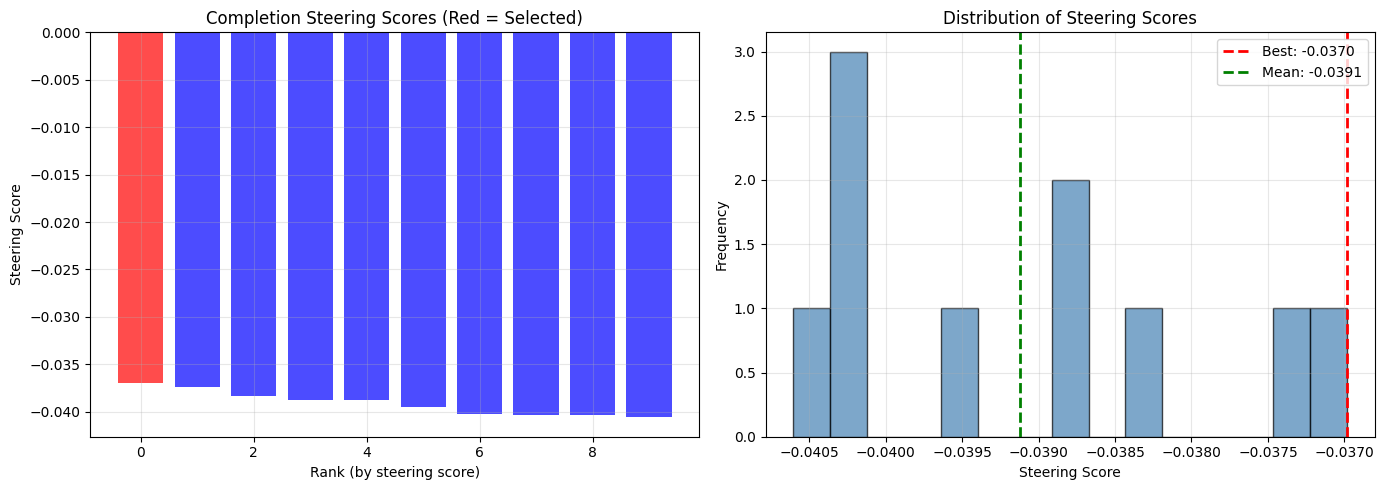


Score Statistics:
  Mean:   -0.039123
  Std:    0.001218
  Min:    -0.040603
  Max:    -0.036984
  Range:  0.003619


In [7]:
import matplotlib.pyplot as plt
import numpy as np

scores = [comp['steering_score'] for comp in all_completions]
indices = [comp['index'] for comp in all_completions]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of scores
colors = ['red' if i == 0 else 'blue' for i in range(len(scores))]
ax1.bar(range(len(scores)), scores, color=colors, alpha=0.7)
ax1.set_xlabel('Rank (by steering score)')
ax1.set_ylabel('Steering Score')
ax1.set_title('Completion Steering Scores (Red = Selected)')
ax1.grid(True, alpha=0.3)

# Histogram
ax2.hist(scores, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(best_score, color='red', linestyle='--', linewidth=2, label=f'Best: {best_score:.4f}')
ax2.axvline(np.mean(scores), color='green', linestyle='--', linewidth=2, label=f'Mean: {np.mean(scores):.4f}')
ax2.set_xlabel('Steering Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Steering Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nScore Statistics:")
print(f"  Mean:   {np.mean(scores):.6f}")
print(f"  Std:    {np.std(scores):.6f}")
print(f"  Min:    {np.min(scores):.6f}")
print(f"  Max:    {np.max(scores):.6f}")
print(f"  Range:  {np.max(scores) - np.min(scores):.6f}")

## 5. Multi-Step Generation with Steering

Generate a longer response by selecting the best completion at each step.


####################################################################################################
RUN 1/10
####################################################################################################

STEP 1/10
Selected completion (score: 0.026870):
<think>
Okay, the user is asking about people who don't read documentation. I need to think about different angles here. First, why do people not read documentation? Maybe they're in a hurry, or they think they can figure things out on their own. Or maybe they find documentation too technical or overwhelming.

Then, what are the consequences? Not reading documentation could lead to mistakes, inefficiency, or even security issues. On the other hand, sometimes people might rely on trial and error,

STEP 2/10
Selected completion (score: 0.006314):
 which can be effective but risky.

I should consider the perspective of different roles. For example, developers might skip docs if they're confident in their skills, while new users mig

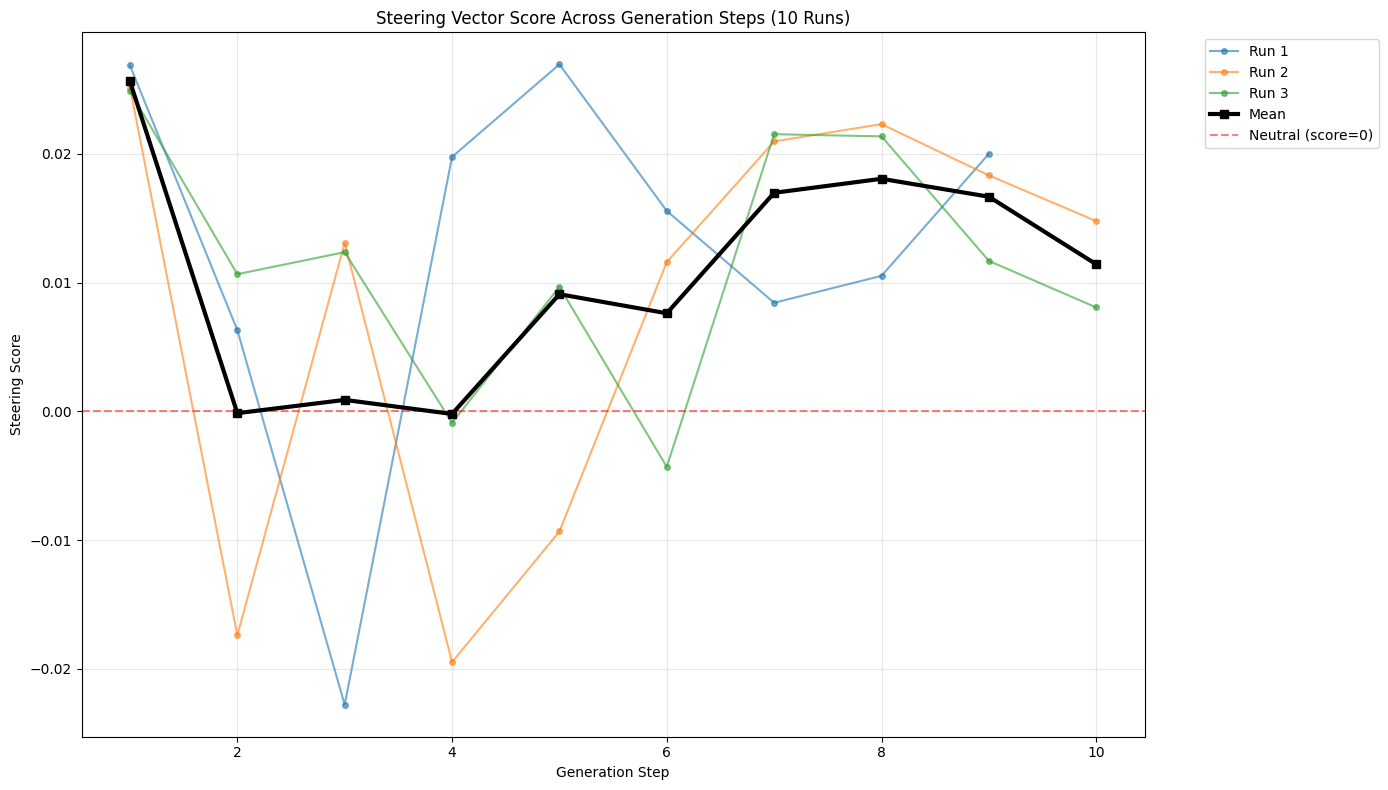


MULTI-RUN SUMMARY
Run 1: 9 steps, Mean score: 0.012408, Final score: 0.020008
Run 2: 10 steps, Mean score: 0.008006, Final score: 0.014781
Run 3: 10 steps, Mean score: 0.011505, Final score: 0.008075

Overall Statistics:
  Total steps across all runs: 29
  Mean score: 0.010579
  Std score: 0.013514
  Min score: -0.022777
  Max score: 0.026956

EXAMPLE FINAL GENERATED TEXT (Run 1)
<think>
Okay, the user is asking about people who don't read documentation. I need to think about different angles here. First, why do people not read documentation? Maybe they're in a hurry, or they think they can figure things out on their own. Or maybe they find documentation too technical or overwhelming.

Then, what are the consequences? Not reading documentation could lead to mistakes, inefficiency, or even security issues. On the other hand, sometimes people might rely on trial and error, which can be effective but risky.

I should consider the perspective of different roles. For example, developers mi

In [5]:
def multi_step_generation(
    selector,
    initial_prompt,
    max_steps=5,
    max_tokens_per_step=50,
    temperature=0.8,
    n_completions=10
):
    """
    Generate text in multiple steps, selecting best completion at each step.
    """
    steps = []
    accumulated_text = ""
    current_prompt = initial_prompt
    
    for step in range(max_steps):
        print(f"\n{'='*80}")
        print(f"STEP {step + 1}/{max_steps}")
        print(f"{'='*80}")
        
        # Generate completions
        formatted_prompt = selector.format_prompt(current_prompt)
        if accumulated_text:
            formatted_prompt += accumulated_text
        
        completions = selector.get_completions(
            prompt=formatted_prompt,
            max_tokens=max_tokens_per_step,
            temperature=temperature,
            n=n_completions
        )
        
        if not completions:
            print("No completions received, stopping.")
            break
        
        # Score and select best
        texts = [c['text'] for c in completions if c['text'].strip()]
        if not texts:
            print("No valid completions, stopping.")
            break
        
        scores = selector.compute_steering_scores(texts)
        best_idx = scores.index(max(scores))
        best_text = texts[best_idx]
        best_score = scores[best_idx]
        
        print(f"Selected completion (score: {best_score:.6f}):")
        print(f"{best_text}")
        
        # Store step data
        steps.append({
            'step': step + 1,
            'text': best_text,
            'score': best_score,
            'n_completions': len(texts)
        })
        
        accumulated_text += best_text
        
        # Check if we should stop
        if any(c.get('finish_reason') == 'stop' for c in completions if c['text'] == best_text):
            print("\nReached stop token, ending generation.")
            break
    
    return accumulated_text, steps


# Run multi-step generation 10 times
initial_prompt = "What do you think about people who don't read documentation?"
all_runs = []

for run_idx in range(3):
    print(f"\n{'#'*100}")
    print(f"RUN {run_idx + 1}/10")
    print(f"{'#'*100}")
    
    final_text, generation_steps = multi_step_generation(
        selector,
        initial_prompt=initial_prompt,
        max_steps=10,
        max_tokens_per_step=100,
        temperature=0.8,
        n_completions=30
    )
    
    all_runs.append({
        'run': run_idx + 1,
        'final_text': final_text,
        'steps': generation_steps
    })
    
    print(f"\nRun {run_idx + 1} completed with {len(generation_steps)} steps")

# Plot all runs on the same graph
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 8))

# Plot each run
colors = plt.cm.tab10(np.linspace(0, 1, 10))
all_scores_by_step = {}

for i, run in enumerate(all_runs):
    steps = [step['step'] for step in run['steps']]
    scores = [step['score'] for step in run['steps']]
    
    # Store scores for mean calculation
    for step, score in zip(steps, scores):
        if step not in all_scores_by_step:
            all_scores_by_step[step] = []
        all_scores_by_step[step].append(score)
    
    plt.plot(steps, scores, 'o-', color=colors[i], alpha=0.6, linewidth=1.5, 
             markersize=4, label=f'Run {i+1}')

# Calculate and plot mean
max_step = max(all_scores_by_step.keys())
mean_steps = []
mean_scores = []

for step in range(1, max_step + 1):
    if step in all_scores_by_step:
        mean_steps.append(step)
        mean_scores.append(np.mean(all_scores_by_step[step]))

plt.plot(mean_steps, mean_scores, 'k-', linewidth=3, marker='s', 
         markersize=6, label='Mean', zorder=10)

plt.xlabel('Generation Step')
plt.ylabel('Steering Score')
plt.title('Steering Vector Score Across Generation Steps (10 Runs)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Neutral (score=0)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*80}")
print("MULTI-RUN SUMMARY")
print(f"{'='*80}")

for i, run in enumerate(all_runs):
    scores = [step['score'] for step in run['steps']]
    print(f"Run {i+1}: {len(run['steps'])} steps, "
          f"Mean score: {np.mean(scores):.6f}, "
          f"Final score: {scores[-1]:.6f}")

# Overall statistics
all_scores = []
for run in all_runs:
    all_scores.extend([step['score'] for step in run['steps']])

print(f"\nOverall Statistics:")
print(f"  Total steps across all runs: {len(all_scores)}")
print(f"  Mean score: {np.mean(all_scores):.6f}")
print(f"  Std score: {np.std(all_scores):.6f}")
print(f"  Min score: {np.min(all_scores):.6f}")
print(f"  Max score: {np.max(all_scores):.6f}")

# Display one example final text
print(f"\n{'='*80}")
print("EXAMPLE FINAL GENERATED TEXT (Run 1)")
print(f"{'='*80}")
print(all_runs[0]['final_text'])

## 6. Compare Different Prompts

Test the steering selector on various prompts to see how it affects selection.

In [7]:
test_prompts = [
    "What do you think about people who ignore instructions?",
    "Describe a typical day at work",
    "How would you handle a difficult customer?",
    "What's your opinion on software bugs?",
    "Explain the weather today"
]

results = []

for prompt in test_prompts:
    print(f"\n{'='*80}")
    print(f"Prompt: {prompt}")
    print(f"{'='*80}")
    
    best_text, best_score, all_comps = selector.select_best_completion(
        prompt=prompt,
        max_tokens=80,
        temperature=0.8,
        n=10,
        verbose=False
    )
    
    results.append({
        'prompt': prompt,
        'best_score': best_score,
        'best_text': best_text[:150] + "..." if len(best_text) > 150 else best_text
    })
    
    print(f"Best Score: {best_score:.6f}")
    print(f"Text: {best_text[:150]}..." if len(best_text) > 150 else f"Text: {best_text}")

# Summarize results
print(f"\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}")
for i, result in enumerate(sorted(results, key=lambda x: x['best_score'], reverse=True)):
    print(f"\n{i+1}. Score: {result['best_score']:.6f}")
    print(f"   Prompt: {result['prompt']}")
    print(f"   Response: {result['best_text'][:80]}...")


Prompt: What do you think about people who ignore instructions?
Best Score: -0.021089
Text: <think>
Okay, so I need to think about people who ignore instructions. Hmm, where do I start? Maybe first, I should consider why people ignore instruc...

Prompt: Describe a typical day at work
Best Score: -0.028356
Text: <think>
Okay, the user wants me to describe a typical day at work. Let me start by thinking about the structure of a typical workday. Maybe I should b...

Prompt: How would you handle a difficult customer?
Best Score: -0.027166
Text: <think>
Okay, so I need to figure out how to handle a difficult customer. Hmm, let's start by thinking about what a difficult customer might be like. ...

Prompt: What's your opinion on software bugs?
Best Score: -0.030069
Text: <think>
Okay, the user is asking for my opinion on software bugs. Let me start by thinking about what I know. First, software bugs are inevitable, rig...

Prompt: Explain the weather today
Best Score: -0.027281
Text: <thin

## 7. Export Results

Save the selected completions for analysis.

In [ ]:
# Save results to JSON
output_data = {
    'multi_step_generation': {
        'prompt': initial_prompt,
        'final_text': final_text,
        'steps': generation_steps
    },
    'prompt_comparison': results
}

output_file = '/workspace/basic_science_resampling/steering_results.json'
with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"Results saved to: {output_file}")

# 8. playing around

In [10]:
selector.__dict__

{'vllm_model': 'Qwen/Qwen3-8b',
 'vllm_url': 'http://localhost:8000/v1/completions',
 'layer_idx': 15,
 'device': device(type='cuda'),
 'tokenizer': Qwen2TokenizerFast(name_or_path='Qwen/Qwen3-4b', vocab_size=151643, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, sin

In [19]:
# ## Scoring Examples from emotion_examples.json
# 
# Let's load and score the examples from the emotion examples file to see how they perform.
import torch
model = selector.model
tokenizer = selector.tokenizer
device = 'cuda'
steering_layer = 15
steering_vector = selector.steering_vector.squeeze()
import json

# Load emotion examples
emotion_examples_file = '/workspace/basic_science_resampling/emotion_examples.json'
with open(emotion_examples_file, 'r') as f:
    emotion_examples = json.load(f)

print(f"Loaded {len(emotion_examples)} emotion examples")

# Score each example
emotion_scores = []
for i, example in enumerate(emotion_examples['angry'][:10] + emotion_examples['neutral'][:10]):
    # Get the text to score - handle both string and dict cases
    if isinstance(example, dict):
        text = example.get('text', str(example))  # if it's a dict, get 'text' field
    else:
        text = str(example)  # if it's already a string, use it directly
    
    # Tokenize and get activations
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        
        # Get activations at the steering layer
        layer_activations = hidden_states[steering_layer]  # [batch, seq_len, hidden_dim]
        
        # Average over sequence length
        avg_activations = layer_activations.mean(dim=1)  # [batch, hidden_dim]
        
        # Compute steering score using cosine similarity
        steering_score = torch.nn.functional.cosine_similarity(avg_activations.squeeze(), steering_vector, dim=0).item()
    
    emotion_scores.append({
        'index': i,
        'text': text[:100] + "..." if len(text) > 100 else text,
        'full_text': text,
        'score': steering_score
    })
    
    if i < 5:  # Print first few for inspection
        print(f"\nExample {i+1}:")
        print(f"Score: {steering_score:.6f}")
        print(f"Text: {text[:150]}...")

# Sort by score
emotion_scores.sort(key=lambda x: x['score'], reverse=True)

print(f"\n{'='*80}")
print("TOP SCORING EMOTION EXAMPLES")
print(f"{'='*80}")
for i, result in enumerate(emotion_scores[:10]):  # Top 10
    print(f"\n{i+1}. Score: {result['score']:.6f}")
    print(f"   Text: {result['text']}")

print(f"\n{'='*80}")
print("LOWEST SCORING EMOTION EXAMPLES")
print(f"{'='*80}")
for i, result in enumerate(emotion_scores[-5:]):  # Bottom 5
    print(f"\n{len(emotion_scores)-4+i}. Score: {result['score']:.6f}")
    print(f"   Text: {result['text']}")


Loaded 2 emotion examples

Example 1:
Score: 0.020808
Text: im grabbing a minute to post i feel greedy wrong...

Example 2:
Score: 0.012327
Text: i think it s the easiest time of year to feel dissatisfied...

Example 3:
Score: 0.019212
Text: i feel irritated and rejected without anyone doing anything or saying anything...

Example 4:
Score: 0.010569
Text: i already feel like i fucked up though because i dont usually eat at all in the morning...

Example 5:
Score: 0.004038
Text: i feel kinda appalled that she feels like she needs to explain in wide and lenghth her body measures etc pp...

TOP SCORING EMOTION EXAMPLES

1. Score: 0.025581
   Text: i feel selfish and spoiled

2. Score: 0.022546
   Text: i stopped feeling cold and began feeling hot

3. Score: 0.020808
   Text: im grabbing a minute to post i feel greedy wrong

4. Score: 0.019212
   Text: i feel irritated and rejected without anyone doing anything or saying anything

5. Score: 0.018811
   Text: i feel more superior dead chick

In [20]:
emotion_scores

[{'index': 8,
  'text': 'i feel selfish and spoiled',
  'full_text': 'i feel selfish and spoiled',
  'score': 0.025580788031220436},
 {'index': 7,
  'text': 'i stopped feeling cold and began feeling hot',
  'full_text': 'i stopped feeling cold and began feeling hot',
  'score': 0.02254590205848217},
 {'index': 0,
  'text': 'im grabbing a minute to post i feel greedy wrong',
  'full_text': 'im grabbing a minute to post i feel greedy wrong',
  'score': 0.02080824039876461},
 {'index': 2,
  'text': 'i feel irritated and rejected without anyone doing anything or saying anything',
  'full_text': 'i feel irritated and rejected without anyone doing anything or saying anything',
  'score': 0.01921248808503151},
 {'index': 16,
  'text': 'i feel more superior dead chicken or grieving child',
  'full_text': 'i feel more superior dead chicken or grieving child',
  'score': 0.018811289221048355},
 {'index': 14,
  'text': 'i have the feeling she was amused and delighted',
  'full_text': 'i have the 